In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Linear Regression

In [2]:
n_samples = 1000
n_features = 1

prng = np.random.RandomState(42)
X = prng.normal(loc=1, scale=1, size=(n_samples, n_features))
eps = prng.normal(size=(n_samples, 1))
y = 4 + 3 * X + eps

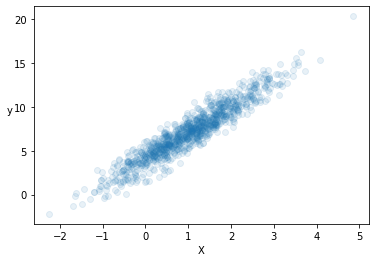

In [3]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")
plt.show()

In [4]:
_intercept = np.ones(shape=(n_samples, 1))
_X = np.hstack((_intercept, X))
theta = np.linalg.inv(_X.T @ _X) @ _X.T @ y

In [5]:
theta

array([[4.11278414],
       [2.95884766]])

In [6]:
# nifty way to sort an array based on a columns values
_X = _X[_X[:, 1].argsort()]
predictions = _X @ theta

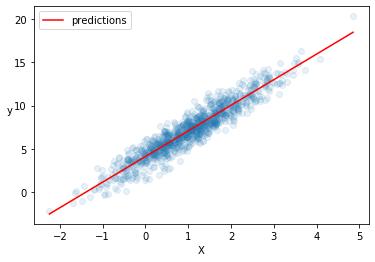

In [7]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.plot(_X[:, 1], predictions[:, 0], label="predictions", color='r')
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")
ax.legend()
plt.show()

In [8]:
from sklearn import linear_model

regressor = linear_model.LinearRegression(fit_intercept=True)
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
regressor.intercept_, regressor.coef_

(array([4.11278414]), array([[2.95884766]]))

In [10]:
# under the hood LinearRegression uses np.linalg.lstsq()
_intercept = np.ones(shape=(n_samples, 1))
_X = np.hstack((_intercept, X))
theta_svd, rss, rank, singular_values = np.linalg.lstsq(_X, y, rcond=None)

In [11]:
theta_svd

array([[4.11278414],
       [2.95884766]])

In [12]:
# under the hood np.linalg.lstsqr() computes the Moore-Penrose inverse of _X computed using SVD
np.linalg.pinv(_X) @ y

array([[4.11278414],
       [2.95884766]])

# Gradient Descent

In [13]:
def gradient(parameters, X, y):
    n_samples, _ = X.shape
    predictions = X @ parameters
    residuals = predictions - y
    return (2 * X.T @ residuals) / n_samples

In [14]:
# should be close to zero vector at optimal parameter vector
gradient(theta_svd, _X, y)

array([[-2.67696976e-15],
       [-5.75228754e-15]])

In [15]:
def update_parameters(parameters, X, y, lr):
    return parameters - lr * gradient(parameters, X, y)

In [16]:
# no change in parameters because gradient is zero
update_parameters(theta_svd, _X, y, 1e-1)

array([[4.11278414],
       [2.95884766]])

In [17]:
def gradient_descent(initial_parameters, X, y, lr, n_iter, rtol):
    parameters = initial_parameters
    for i in range(n_iter):
        updated_parameters = update_parameters(parameters, X, y, lr)
        if np.linalg.norm(updated_parameters - parameters) < rtol:
            print(f"Gradient descent terminated after {i} out of {n_iter} iterations.")
            break
        else:
            parameters = updated_parameters
    return updated_parameters

In [18]:
# randomly initialize parameters
_prng = np.random.RandomState(42)
initial_parameters = _prng.normal(size=(2,1))

gradient_descent(initial_parameters, _X, y, lr=1e-1, n_iter=1000, rtol=1e-8)

Gradient descent terminated after 214 out of 1000 iterations.


array([[4.11278403],
       [2.95884773]])

## Stochastic Gradient Descent

In [19]:
def learning_rate_schedule(t):
    return t0 / (t + T)

def stochastic_gradient_descent(initial_parameters, X, y, n_epochs, random_state):
    parameters = initial_parameters
    n_samples, _ = X.shape
    for i in range(n_epochs):
        for j in range(n_samples):
            idx = random_state.randint(n_samples)
            lr = learning_rate_schedule(i * n_samples + j)
            parameters = update_parameters(parameters, X[[idx]], y[[idx]], lr)
    return parameters

In [20]:
# randomly initialize parameters
_prng = np.random.RandomState(42)
initial_parameters = _prng.normal(size=(2,1))

# hyperparameters for tuning the learning rate
t0, T = 5, 50

stochastic_gradient_descent(initial_parameters, _X, y, n_epochs=50, random_state=_prng)


array([[4.11766061],
       [2.94549277]])

In [23]:
from sklearn import linear_model

In [24]:
linear_model.SGDRegressor?

Init signature:
linear_model.SGDRegressor(
    loss='squared_loss',
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    random_state=None,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    warm_start=False,
    average=False,
)
Docstring:     
Linear model fitted by minimizing a regularized empirical loss with SGD

SGD stands for Stochastic Gradient Descent: the gradient of the loss is
estimated each sample at a time and the model is updated along the way with
a decreasing strength schedule (aka learning rate).

The regularizer is a penalty added to the loss function that shrinks model
parameters towards the zero vector using either the squared euclidean norm
L2 or the absolute norm L1 or a combination of both (Elastic Net). If the
parameter update crosses the 0.0 value becaus

In [47]:
# since we manually added a column vector of ones as a feature we set fit_intercept=False
_prng = np.random.RandomState(42)
sgd_regressor = linear_model.SGDRegressor(fit_intercept=False, random_state=_prng)

_y = y.ravel()
sgd_regressor.fit(_X, _y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25,
             random_state=RandomState(MT19937) at 0x113E5F990, shuffle=True,
             tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
sgd_regressor.coef_

array([4.11644994, 2.96518252])

## Mini-batch Gradient Descent

In [52]:
def minibatch_gradient_descent(initial_parameters, X, y, lr, n_epochs, batch_size, random_state):
    parameters = initial_parameters
    n_samples, _ = X.shape
    n_batches = (n_samples // batch_size) + 1
    for i in range(n_epochs):
        for j in range(n_batches):
            idxs = random_state.randint(n_samples, size=batch_size)
            parameters = update_parameters(parameters, X[idxs], y[idxs], lr)
    return parameters

In [54]:
# randomly initialize parameters
_prng = np.random.RandomState(42)
initial_parameters = _prng.normal(size=(2,1))

minibatch_gradient_descent(initial_parameters, _X, y, n_epochs=50, batch_size=64, lr=1e-1, random_state=_prng)


array([[4.13316254],
       [2.98584814]])

# Polynomial Regression

In [78]:
n_samples = 1000
n_features = 1

prng = np.random.RandomState(42)
X = 6 * prng.normal(loc=1, scale=0.25, size=(n_samples, n_features)) - 3
eps = prng.normal(loc=0, scale=1, size=(n_samples, 1))

y = 0.5 * X**2 + X + 2 + eps

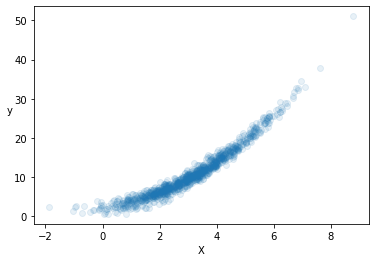

In [79]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")
plt.show()

In [147]:
from sklearn import preprocessing

# set include_bias=False to avoid singular matrix with fit_intercept=True
polynomial_features = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
Z = polynomial_features.fit_transform(X)

linear_regressor = linear_model.LinearRegression(fit_intercept=True)
linear_regressor.fit(Z, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [148]:
# true values are 2, 1, 0.5
linear_regressor.coef_

array([[0.91469475, 0.50928977]])

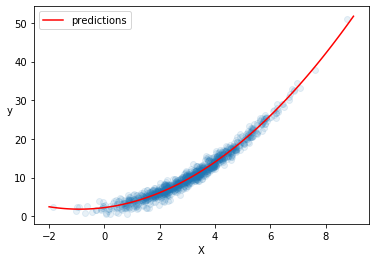

In [149]:
# generate some new predictions for pretty plotting
_X = (np.linspace(-2, 9, 100)
        .reshape(-1, 1))
_Z = polynomial_features.transform(_X)
predictions = linear_regressor.predict(_Z)

fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.plot(_X[:, 0], predictions[:, 0], label="predictions", color='r')
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")
ax.legend()
plt.show()

# Learning Curves

In [114]:
from sklearn import metrics
from sklearn import model_selection


def plot_learning_curves(model, X, y, ax):
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(metrics.mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_squared_error(y_val, y_val_predict))
    
    ax.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    ax.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    ax.legend()

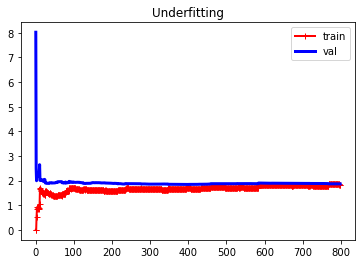

In [144]:
linear_regressor = linear_model.LinearRegression(fit_intercept=True)
fig, ax = plt.subplots(1, 1)
plot_learning_curves(linear_regressor, X, y, ax)
_ = ax.set_title("Underfitting")

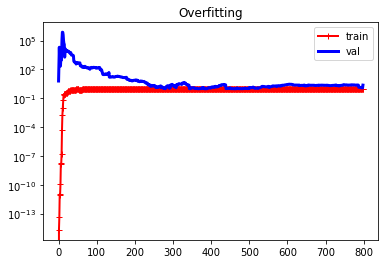

In [145]:
polynomial_features = preprocessing.PolynomialFeatures(degree=10, include_bias=False)
Z = polynomial_features.fit_transform(X)

fig, ax = plt.subplots(1, 1)
plot_learning_curves(linear_regressor, Z, y, ax)
ax.set_yscale("log")
_ = ax.set_title("Overfitting")

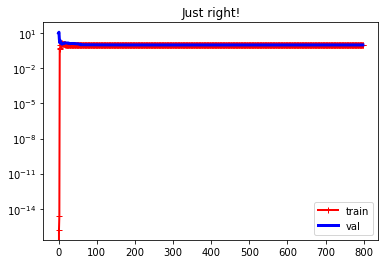

In [146]:
polynomial_features = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
Z = polynomial_features.fit_transform(X)

fig, ax = plt.subplots(1, 1)
plot_learning_curves(linear_regressor, Z, y, ax)
ax.set_yscale("log")
_ = ax.set_title("Just right!")

# Regularized Linear Models

## Ridge Regression

In [152]:
from sklearn import pipeline


preprocessing_pipeline = pipeline.Pipeline([
    ("polynomial_features", preprocessing.PolynomialFeatures(degree=15, include_bias=False)),
    ("standard_scaler", preprocessing.StandardScaler())
])
Z = preprocessing_pipeline.fit_transform(X)

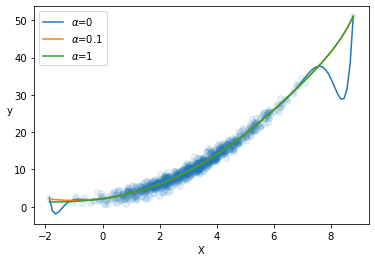

In [169]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")

_prng = np.random.RandomState(42)

alphas = [0, 1e-1, 1]
for alpha in alphas:
    # uses exact solution to the normal equations via matrix decomposition (slow for large n_features)
    ridge_model = linear_model.Ridge(alpha, fit_intercept=True, random_state=_prng)
    ridge_model.fit(Z, y)
    
    _X = (np.linspace(X.min(), X.max(), 100)
            .reshape(-1, 1))
    _Z = preprocessing_pipeline.transform(_X)
    _predictions = ridge_model.predict(_Z)
    
    ax.plot(_X[:, 0], _predictions[:, 0], label=rf"$\alpha$={alpha}")

ax.legend()
plt.show()

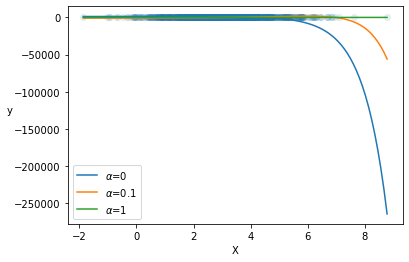

In [170]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")

_prng = np.random.RandomState(42)

alphas = [0, 1e-1, 1]
for alpha in alphas:
    ridge_model = linear_model.SGDRegressor(penalty="l2", alpha=alpha, fit_intercept=True, random_state=_prng)
    ridge_model.fit(Z, _y)
    
    _X = (np.linspace(X.min(), X.max(), 100)
            .reshape(-1, 1))
    _Z = preprocessing_pipeline.transform(_X)
    _predictions = ridge_model.predict(_Z)
    
    ax.plot(_X[:, 0], _predictions, label=rf"$\alpha$={alpha}")

ax.legend()
plt.show()

## Lasso Regression

/Users/pughdr/Training/scikit-learn-tutorials/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.1383631220866, tolerance: 3.9470806632103144
  positive)


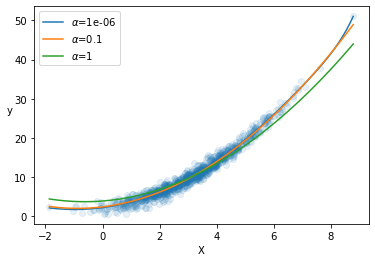

In [197]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")

_prng = np.random.RandomState(42)

alphas = [1e-6, 1e-1, 1]
for alpha in alphas:
    # uses exact solution to the normal equations via matrix decomposition (slow for large n_features)
    lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True, max_iter=2000, random_state=_prng)
    lasso_model.fit(Z, y)
    
    _X = (np.linspace(X.min(), X.max(), 100)
            .reshape(-1, 1))
    _Z = preprocessing_pipeline.transform(_X)
    _predictions = lasso_model.predict(_Z)
    
    ax.plot(_X[:, 0], _predictions, label=rf"$\alpha$={alpha}")

ax.legend()
plt.show()

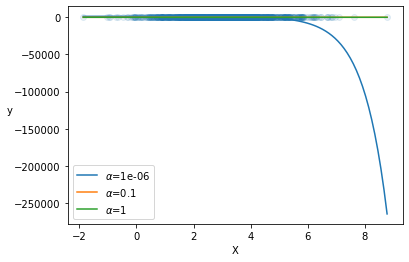

In [201]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], y[:, 0], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('y', rotation="horizontal")

_prng = np.random.RandomState(42)

alphas = [1e-6, 1e-1, 1]
for alpha in alphas:
    lasso_model = linear_model.SGDRegressor(penalty="l1", alpha=alpha, fit_intercept=True, max_iter=2000, random_state=_prng)
    lasso_model.fit(Z, _y)
    
    _X = (np.linspace(X.min(), X.max(), 100)
            .reshape(-1, 1))
    _Z = preprocessing_pipeline.transform(_X)
    _predictions = lasso_model.predict(_Z)
    
    ax.plot(_X[:, 0], _predictions, label=rf"$\alpha$={alpha}")

ax.legend()
plt.show()

## ElasticNet Regression